In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import os

38      0.003209
39      0.008872
40      0.003903
41      0.001897
42      0.007962
          ...   
3780    0.080833
3781    0.051327
3782    0.004233
3783    0.033500
3784    0.022543
Name: likes, Length: 3618, dtype: float64


In [80]:
# Set plot style for better visuals
sns.set(style='whitegrid')
data = pd.read_csv('./instagram_data.csv')

# print(data)

# Extract useful features
# data['engagement_rate'] = (data.no_of_comments + data.likes) / data.follower_count_at_t
data['post_time'] = pd.to_datetime(data['t'], unit='s')

# Create cyclical encodings as this time data is cyclical
data['hour_sin'] = np.sin(2 * np.pi * data['post_time'].dt.hour / 24)  # Extract hour of the day (0-23)
data['hour_cos'] = np.cos(2 * np.pi * data['post_time'].dt.hour / 24)  # Extract hour of the day (0-23)

data['day_sin'] = np.sin(2 * np.pi * data['post_time'].dt.dayofweek / 7)  # Extract day of the week (0=Monday, 6=Sunday)
data['day_cos'] = np.cos(2 * np.pi * data['post_time'].dt.dayofweek / 7)

data['month_sin'] = np.sin(2 * np.pi * data['post_time'].dt.month / 12)  # Extract the month (1-12)
data['month_cos'] = np.cos(2 * np.pi * data['post_time'].dt.month / 12)

# Drop the original timestamp column if no longer needed
data.drop(columns=['t'], inplace=True)
data = data.drop(columns=['image_path'])
data = data.drop(columns = ['post_time'])

# Delete outliers
data = data[data.no_of_comments < 10000]
data = data[data.no_of_comments > 0]

# !Uncomment if including no_of_comments
data = data.drop(columns= ['no_of_comments']) 

# Sample 318 rows for testing
test_samples = data.sample(n=318, random_state=42)

In [81]:
# Create x_test (all columns except 'likes') and y_test ('likes' column)
x_test = test_samples.drop(columns=['likes'])
y_test = test_samples[['likes']]
x_train = data.drop(test_samples.index).drop(columns=['likes'])
y_train = data.drop(test_samples.index)[['likes']]

# Train a linear regression model
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

# Predict on test data
y_pred_lr = lr_model.predict(x_test)

# Evaluate the performance
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train.values.ravel())  # Flatten y_train for RandomForest

# Predict on test data
y_pred_rf = rf_model.predict(x_test)

# Evaluate the performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Train a Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(x_train, y_train.values.ravel())

# Predict on test data
y_pred_gb = gb_model.predict(x_test)

# Evaluate the performance
mse_gb = mean_squared_error(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

# XGBoost
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1, max_depth=4, alpha=10, n_estimators=1000) 
xg_reg.fit(x_train, y_train)

# Predict on the test set
y_pred_xgb = xg_reg.predict(x_test)

# Evaluate the performance
mse_gb = mean_squared_error(y_test, y_pred_xgb)
mae_gb = mean_absolute_error(y_test, y_pred_xgb)
r2_gb = r2_score(y_test, y_pred_xgb)

Linear Regression - MSE: 28336931515.929176, MAE: 125390.50283325813, R2: 0.06684695746283564
Random Forest - MSE: 11478528453.48231, MAE: 71002.92254690621, R2: 0.6220048121937523
Gradient Boosting - MSE: 10568007971.789333, MAE: 71633.93785047231, R2: 0.6519888639450073
XGBoost - MSE: 10568007971.789333, MAE: 71633.93785047231, R2: 0.6519888639450073


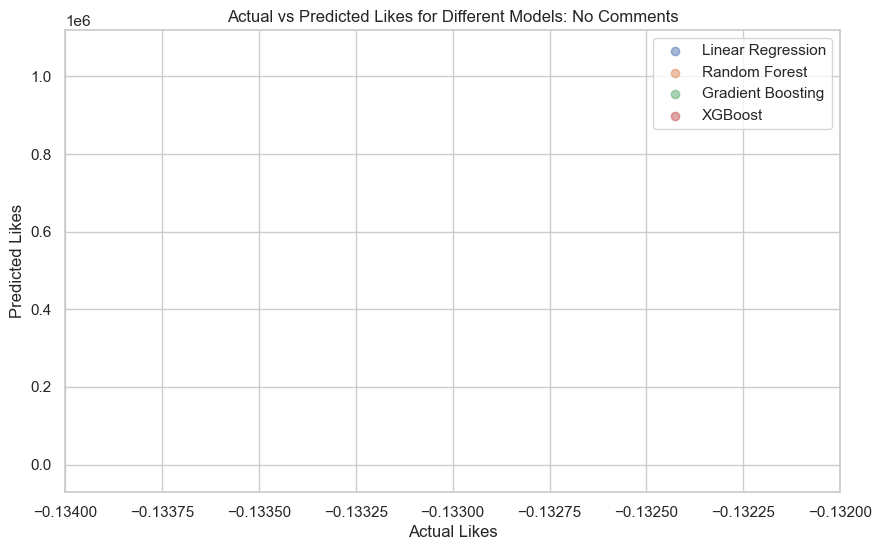

In [82]:
print(f"Linear Regression - MSE: {mse_lr}, MAE: {mae_lr}, R2: {r2_lr}")
print(f"Random Forest - MSE: {mse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Gradient Boosting - MSE: {mse_gb}, MAE: {mae_gb}, R2: {r2_gb}")
print(f"XGBoost - MSE: {mse_gb}, MAE: {mae_gb}, R2: {r2_gb}")
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_lr, label='Linear Regression', alpha=0.5)
plt.scatter(y_test, y_pred_rf, label='Random Forest', alpha=0.5)
plt.scatter(y_test, y_pred_gb, label='Gradient Boosting', alpha=0.5)
plt.scatter(y_test, y_pred_xgb, label='XGBoost', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Likes')
plt.ylabel('Predicted Likes')
plt.title('Actual vs Predicted Likes for Different Models: No Comments')
plt.legend()
# plt.xlim(-0.134, -0.132)
# plt.ylim(0,5)
plt.show()